In [1]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2 
import pytesseract
import numpy as np
import os
from pytesseract import Output
from pre_process import *
from utils import *
import re


DATA_PATH = "../../data"


# Removal shadow 

- The main idea is to extract, segment the text from each channels by using Background subtraction (BS) from grayscale image, which is a common and widely used technique for generating a foreground mask 

- BS calculates the foreground mask performing a subtraction between the current frame and a background model, containing the static part of the scene or, more in general, everything that can be considered as background given the characteristics of the observed scene.

- The purpose is to remove shadow of each channels (convert background into white or black) and then merge back each channels into a image.  

In [2]:
shadow_img = DATA_PATH + '/' + 'shadow_page_book.png'
img   = cv2.imread(shadow_img)
b,g,r = cv2.split(img) 

Text(0.5, 1.0, 'red')

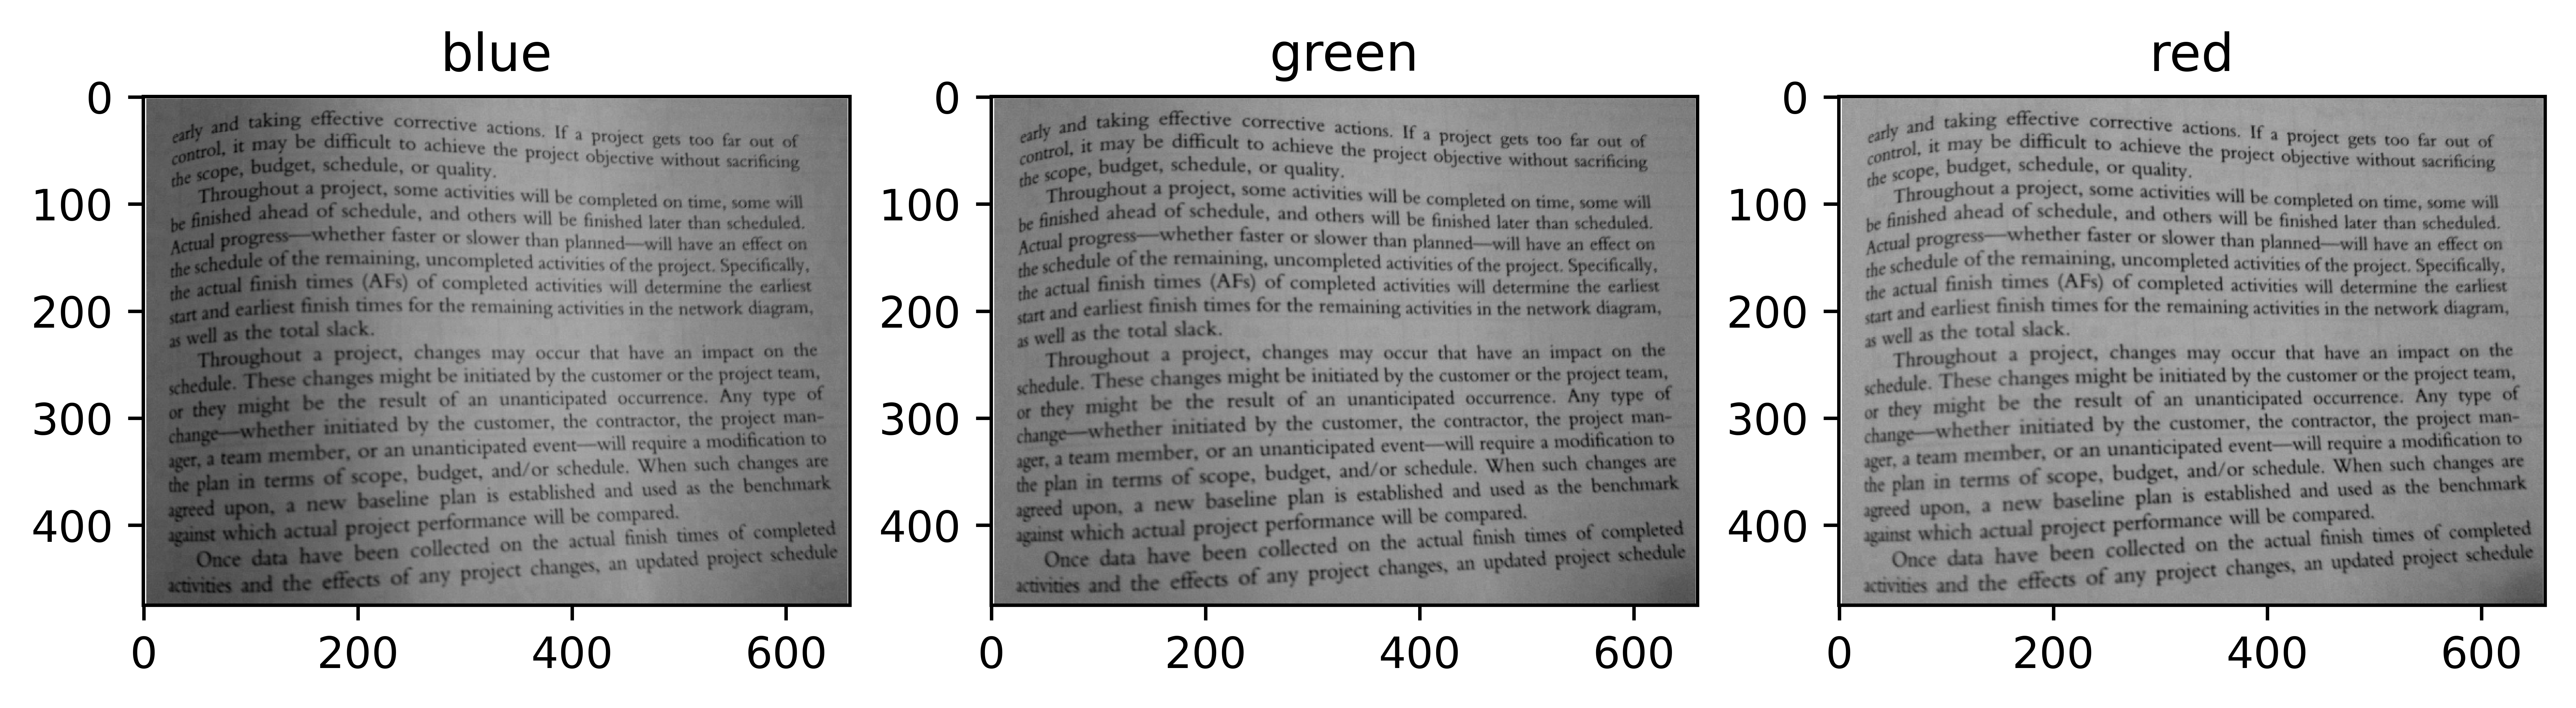

In [3]:
fig, axs = plt.subplots(1, 3)

fig.set_dpi(1000)
fig.set_size_inches(10,20)
axs[0].imshow(b, cmap='gray')
axs[0].set_title('blue')
axs[1].imshow(g, cmap='gray')
axs[1].set_title('green')
axs[2].imshow(r, cmap='gray')
axs[2].set_title('red')

Take a look a three pictures, we can see the amount of shadow in blue in channel is the most distributed

## First step

Extract the background by making blur the part of text, morphological operations are useful right now. 

- Grayscale dilation of an image involes assigning to each pixel, the maximum value found over the neighborhood of the structuring element, by using a square kernel with oden dimensional 
- The dilated value of a pixel x is the maximum value of the image in the neighborhood defined

Dilation is considered as a type of morphological openration,  morphological operations are the set of operations that process images according to their shapes.
As the kernel B is scanned over the image, we compute the maximal pixel value overlapped by B and replace the image pixel in the anchor point position with that maximal value. As you can deduce, with background withe and black text, this maximizing operation causes dark regions within an image to reduce. Bigger size of kernel is, blurer text is. they are transfered as noise as we need to remove. 

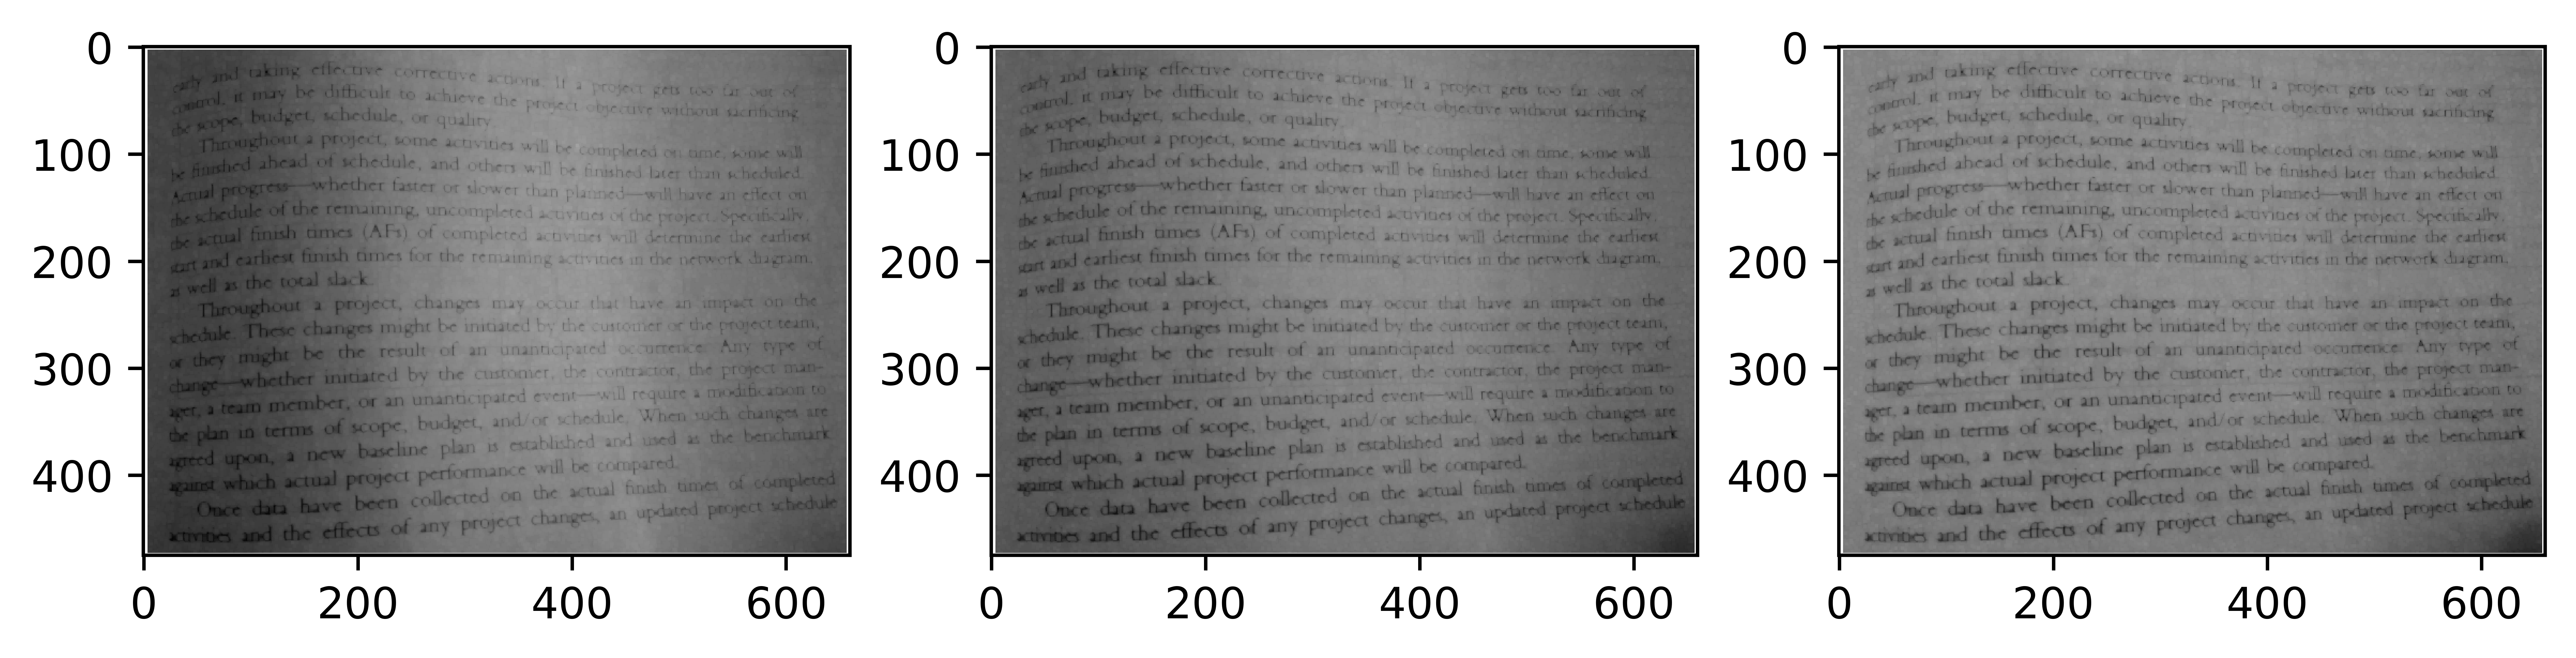

In [4]:
rgb_planes = cv2.split(img)
fig, axs = plt.subplots(1, 3)
fig.set_dpi(1000)
fig.set_size_inches(10,20)

i = 0

for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((3,3), np.uint8))
    axs[i].imshow(dilated_img, cmap = 'gray')
    i = i + 1


## Second step 

Median Blur help smoothing image and remove noise produced from previous operations. They take each background more generally.

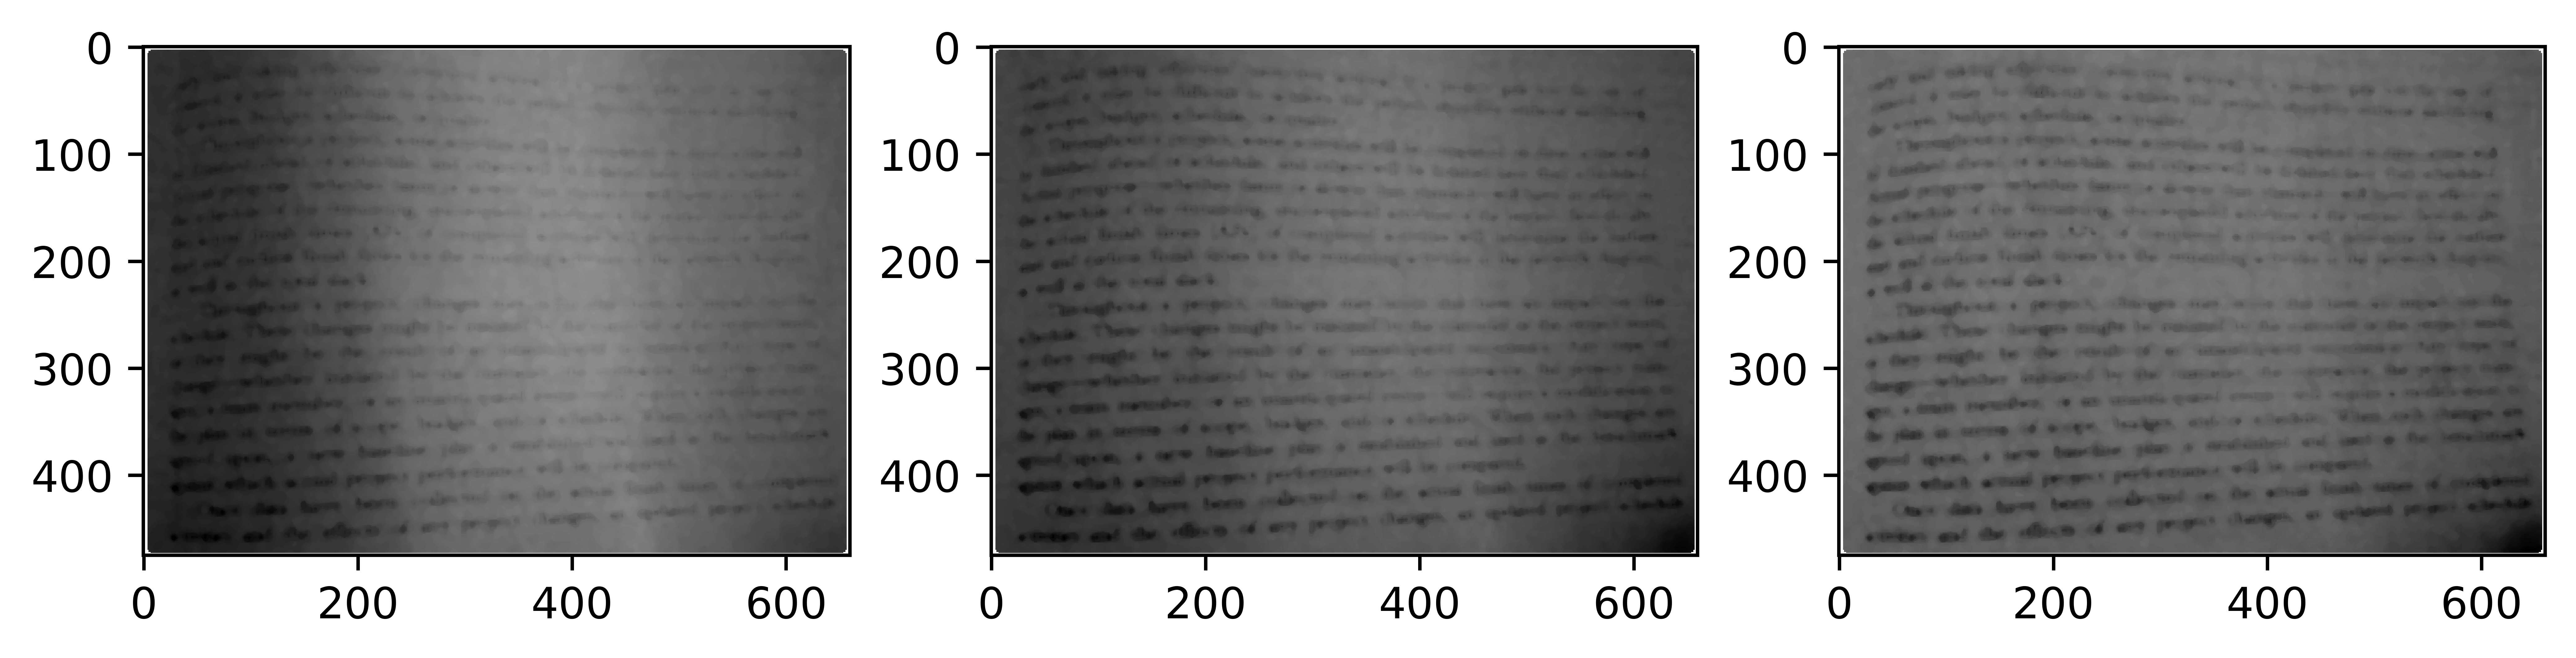

In [5]:
fig, axs = plt.subplots(1, 3)
fig.set_dpi(1000)
fig.set_size_inches(10,20)
i = 0
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((3,3), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 7)
    axs[i].imshow(bg_img, cmap = 'gray')
    i = i + 1


## Third step 

cv2.absdiff is a function which helps in finding the absolute difference between the pixels of the two image arrays. By using this we will be able to extract just the pixels of the objects text. Or on the other way, the background become white, shadow is all removed. 


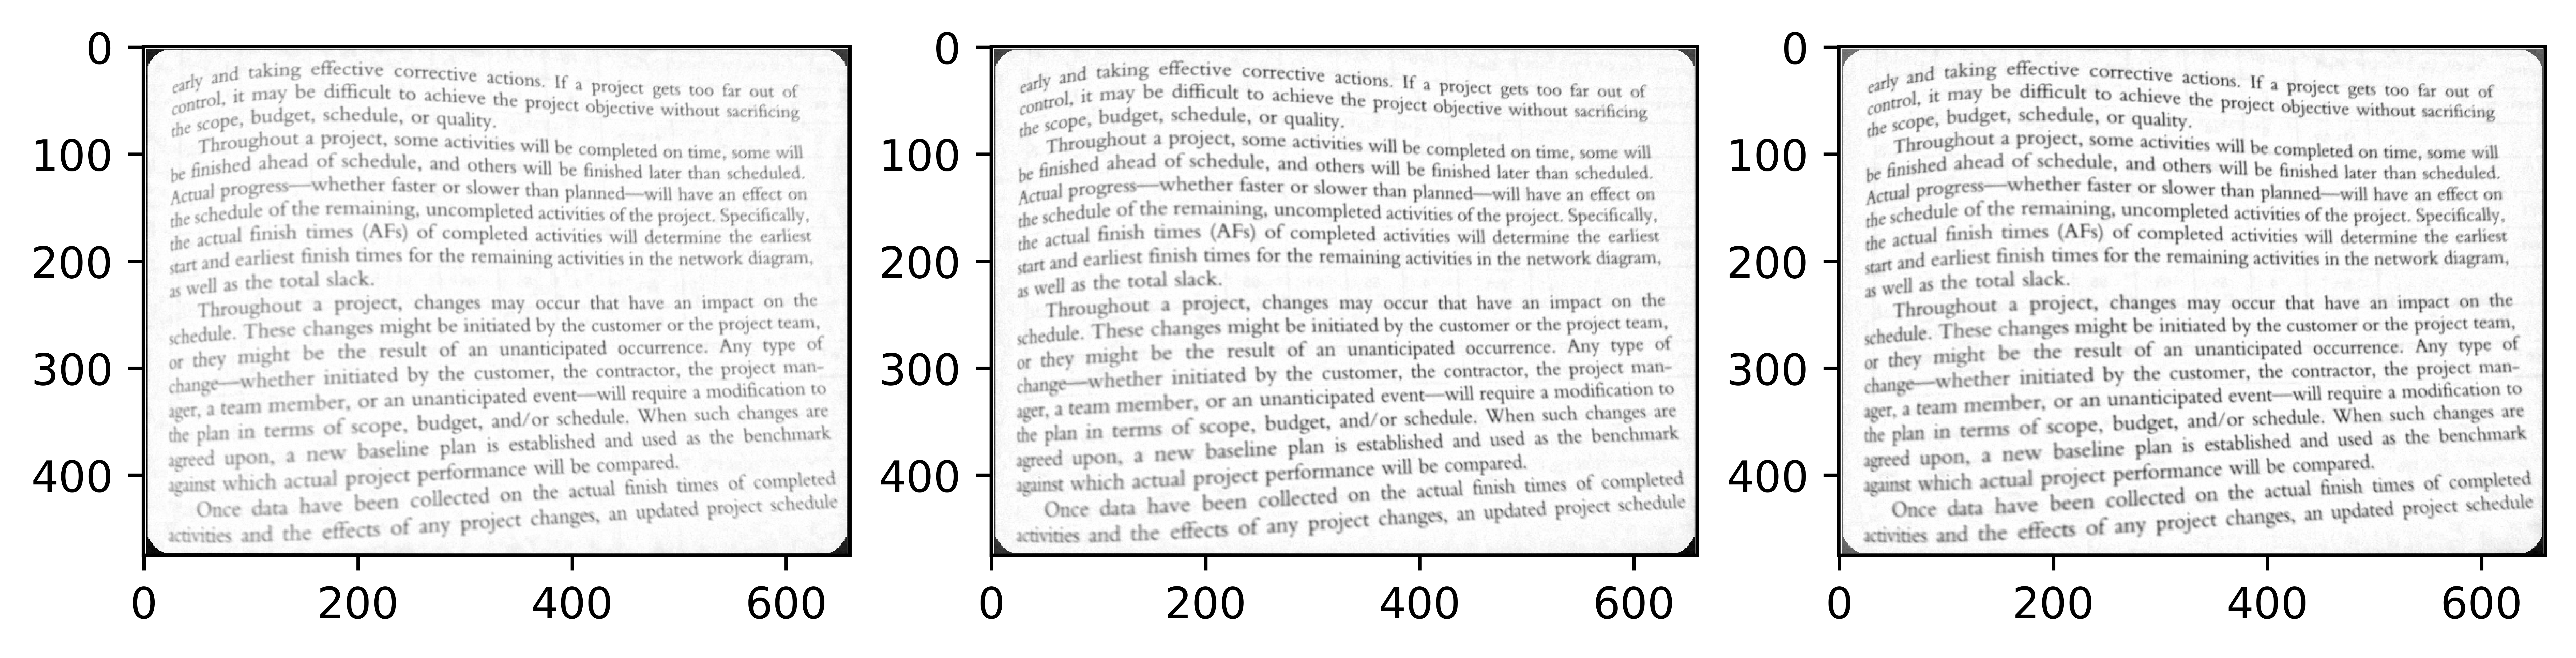

In [10]:
fig, axs = plt.subplots(1, 3)
fig.set_dpi(1000)
fig.set_size_inches(10,20)
i = 0
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((3,3), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 31)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    axs[i].imshow(diff_img, cmap = 'gray')
    i = i + 1


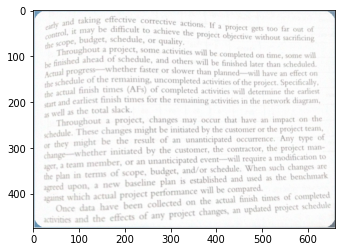

In [19]:
result_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((3,3), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 31)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    result_planes.append(diff_img)
    result = cv2.merge(result_planes)

plt.imshow(result)

# Skew texting 

In [4]:
 #skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

In [5]:
from sklearn.feature_extraction import img_to_graph

PSM0_PATH = DATA_PATH + "/psm0"
img_path = PSM0_PATH + "/org_45.png"
img = cv2.imread(img_path)


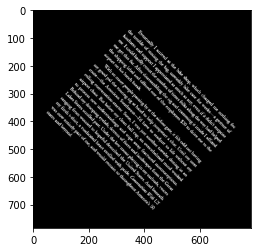

In [6]:


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
# threshold the image, setting all foreground pixels to
# 255 and all background pixels to 0
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.imshow(thresh, cmap='gray')

In [27]:
# grab the (x, y) coordinates of all pixel values that
# are greater than zero, then use these coordinates to
# compute a rotated bounding box that contains all
# coordinates
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]

coords

array([[ 72, 345],
       [ 72, 386],
       [ 73, 345],
       ...,
       [716, 429],
       [716, 430],
       [716, 431]])

In [28]:
angle

45.0

In [23]:
# the `cv2.minAreaRect` function returns values in the
# range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we
# need to add 90 degrees to the angle
if angle < -45:
	angle = -(90 + angle)
# otherwise, just take the inverse of the angle to make
# it positive
else:
	angle = -angle

In [26]:
angle

-45.0

In [24]:
# rotate the image to deskew it
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, 45, 1.0)
rotated = cv2.warpAffine(img, M, (w, h),
	flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

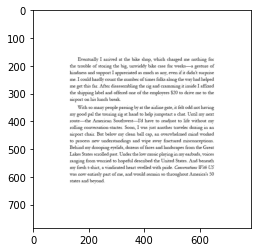

In [25]:
plt.imshow(rotated)

In [5]:
from pre_process import *


def deskew(image):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    
    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255,
	         cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    coords = np.column_stack(np.where(thresh > 0))

    angle = cv2.minAreaRect(coords)[-1]
    print(angle)

    angle = 90 - angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    plt.imshow(rotated)


0 <= angle <= 90
    => minAreaRect => out = 90 - angle => angle can quay la 90 - out

90 < angle < 180
    => minAreaRect => out = 180 - angle => angle can quay la 180 - out

180 <= angle <= 270
    => minAreaRect => out = 270 - angle => angle can quay la 270 - out
 
270 <= angle <= 360
    => minAreaRect => out = 360 - angle => angle can quay la 360 - out
 

69.99188995361328


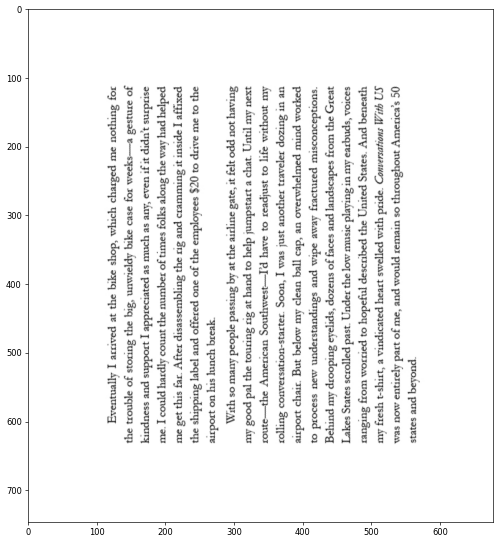

In [7]:
PSM0_PATH = DATA_PATH + "/psm0"
img_path = PSM0_PATH + "/org_290.png"
img = cv2.imread(img_path)


fig, axs = plt.subplots(1,1)
fig.set_dpi(60)
fig.set_size_inches(10,20)

deskew(img)

# Perspective correction

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'drawContours'
> Overload resolution failed:
>  - Can't parse 'contours'. Sequence item with index 0 has a wrong type
>  - Can't parse 'contours'. Sequence item with index 0 has a wrong type


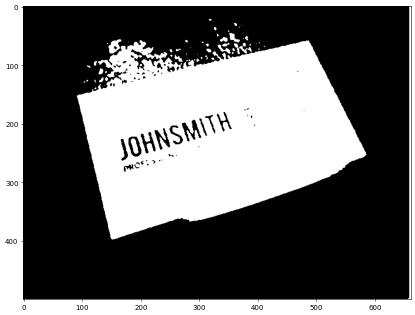

In [84]:
import imutils
fig, axs = plt.subplots(1, 1)
fig.set_dpi(50)
fig.set_size_inches(10,20)
PSM0_PATH = DATA_PATH + "/perspective_trans"
img_path = PSM0_PATH + "/test2.png"


def edge_detection(img_path):

    # *********   Preprocessing  ****************
    #  Read input 
    img = cv2.imread(img_path)
    #  The coordinates change the same way 
    ratio = img.shape[0] / 500.0
    orig = img.copy()
    img = imutils.resize(img, height=500)
    #  Preprocessing 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(blur, 0, 255,
    	     cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]    
    plt.imshow(thresh, cmap='gray')

 #   plt.imshow(edged, cmap = 'gray')

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts,key=cv2.contourArea,reverse=True)[:5]
    
    screenCnt = []
    for i in cnts :

        perimeter = cv2.arcLength(i,True)
        approx = cv2.approxPolyDP(i,0.02*perimeter,True)

        if len(approx) == 4 :
            screenCnt = approx
            break


    cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 2)


edge_detection(img_path)


In [ ]:
# screenCnt  Is the coordinate value of the four vertices , But we need to restore the image here , That's multiplied by the previous ratio 
#  Perspective transformation    Here we need to restore the transformed points to the original coordinates 

In [ ]:
# *************   Contour detection  ****************
#  Contour detection 
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

for c in cnts:
	peri = cv2.arcLength(c, True)

	approx = cv2.approxPolyDP(c, 0.02*peri, True)

	if len(approx) == 4:
		screenCnt = approx
		break

res = cv2.drawContours(image, [screenCnt], -1, (0,255,0), 2)

In [3]:
PSM0_PATH  = DATA_PATH + "/perspective_trans"
img_path   = PSM0_PATH + "/test3.png"
img_path1  = DATA_PATH + "/deskew0.jpg" 
img = cv2.imread(img_path1)


NameError: name 'DATA_PATH' is not defined

In [8]:

cv2.imshow('image window', img)
# add wait key. window waits until user presses a key
cv2.waitKey(0)
# and finally destroy/close all open windows
cv2.destroyAllWindows()

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/tranquochung/.local/lib/python3.10/site-packages/cv2/qt/plugins"


In [3]:
cv2.waitKey(0)# All points are in format [cols, rows]
pt_A = [36, 28]
pt_B = [3, 363]
pt_C = [295, 360]
pt_D = [248, 29]

# Here, I have used L2 norm. You can use L1 also.
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))


height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))


input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])


# Compute the perspective transform M
M = cv2.getPerspectiveTransform(input_pts,output_pts)
out = cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)


# show the original and warped images
cv2.imshow("Original", img)
cv2.imshow("Warped", out)
cv2.waitKey(0)

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/tranquochung/.local/lib/python3.10/site-packages/cv2/qt/plugins"


In [3]:
pip install PyQt5

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 3.9 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.7/359.7 KB 7.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 7.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys

from PyQt5.QtCore import *
from PyQt5.QtGui import *
from PyQt5.QtWidgets import *


class MyWidget(QWidget):
    def __init__(self):
        super().__init__()
        self.setGeometry(30,30,1000,400)
        self.begin = QPoint()
        self.end = QPoint()
        self.show()

    def paintEvent(self, event):
        qp = QPainter(self)
        br = QBrush(QColor(100, 10, 10, 40))  
        qp.setBrush(br)   
        qp.drawRect(QRect(self.begin, self.end))       

    def mousePressEvent(self, event):
        self.begin = event.pos()
        self.end = event.pos()
        # print(f"press begin {self.begin}")
        # print(f"press end   {self.end}")
        self.update()

    def mouseMoveEvent(self, event):
        self.end = event.pos()
        self.update()

    def mouseReleaseEvent(self, event):
        #self.begin = event.pos()
        self.end = event.pos()
        #self.update()
        print(f"begin {self.begin}")
        print(f"end   {self.end}")



if __name__ == '__main__':
    app = QApplication(sys.argv)
    window = MyWidget()
    window.show()
    app.aboutToQuit.connect(app.deleteLater)
    sys.exit(app.exec_())

QSocketNotifier: Can only be used with threads started with QThread


begin PyQt5.QtCore.QPoint(413, 72)
end   PyQt5.QtCore.QPoint(621, 205)


SystemExit: 0